In [1]:
%matplotlib inline
import os

import rasterio
import random
import json
import sys
import datacube
import matplotlib
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from geopy.geocoders import Nominatim 
from shapely import speedups
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import triangulate
from shapely.strtree import STRtree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deafrica_tools.plotting import display_map, map_shapefile, plot_lulc, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.geometry import Geometry
from deafrica_tools.spatial import xr_rasterize

import matplotlib.colors as mcolors

In [2]:
create_local_dask_cluster()

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36617
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44099'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45091', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45091
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:32928
INFO:distributed.scheduler:Receive client connection: Client-95ac6c5b-3ab7-11ef-81de-be45a5b18361
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:32942


<Client: 'tcp://127.0.0.1:36617' processes=1 threads=15, memory=97.21 GiB>

In [3]:
dc = datacube.Datacube(app="Monitoring_seagrass")

In [4]:
AMPs_SN = gpd.read_file("AMP_SN_2023.geojson").set_crs(32628)

In [5]:
#AMPs_SN

In [6]:
idx = AMPs_SN[AMPs_SN['APNAME'] == "Kaalolal Blouf-Fogny"].index[0]
geom = Geometry(geom=AMPs_SN.iloc[idx].geometry, crs=AMPs_SN.crs)

In [7]:
gdf = AMPs_SN[AMPs_SN['APNAME'] == "Kaalolal Blouf-Fogny"].set_crs(32628)
map_shapefile(gdf, attribute = 'APNAME')

Label(value='')

Map(center=[12.922444505112633, -16.42177707172945], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [8]:
time = ("2023-01", "2023-03") 
sample_frequency="5D" 
tide_range = (0.25, 0.75)  # tide_range = (0.25, 0.75)

In [9]:
# Create a reusable query

query = {
    "geopolygon": geom,
    "resolution": (-10, 10),
    "output_crs":"EPSG:32628",
    "group_by": "solar_day",
    "time": time,
     
    }


# Load available data from Sentinel-2A and -2B and filter to retain only times
# with at least 80% good data
sentinel_2_ds = load_ard(dc=dc, 
              products=["s2_l2a"],
              min_gooddata=0.9,
              measurements =["red_edge_1", "red","green","blue","nir"],      
              
              **query)
# min_gooddata=0.9,

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 26 out of 36 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 26 time steps


In [11]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 26, y: 4445, x: 4283)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-02T11:47:50 ... 2023-03-30T11:...
  * y            (y) float64 1.451e+06 1.451e+06 ... 1.407e+06 1.407e+06
  * x            (x) float64 3.244e+05 3.244e+05 ... 3.672e+05 3.672e+05
    spatial_ref  int32 32628
Data variables:
    red_edge_1   (time, y, x) float32 953.0 953.0 924.0 ... 1.629e+03 1.431e+03
    red          (time, y, x) float32 526.0 522.0 518.0 ... 896.0 894.0 952.0
    green        (time, y, x) float32 561.0 574.0 565.0 ... 810.0 806.0 821.0
    blue         (time, y, x) float32 439.0 434.0 434.0 ... 533.0 482.0 543.0
    nir          (time, y, x) float32 2.05e+03 2.118e+03 ... 2.99e+03 2.78e+03
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref

In [12]:
tidepost_lat = 12.43  
tidepost_lon = -16.78   

# Calculate tides for each timestep in the satellite dataset
sentinel_2_ds = tidal_tag(ds=sentinel_2_ds, tidepost_lat=tidepost_lat, tidepost_lon=tidepost_lon)

# Print the output dataset with new `tide_height` variable
print(sentinel_2_ds)

# Calculate tides for each timestep in the satellite dataset
#sentinel_2_ds = tidal_tag(ds=sentinel_2_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
#print(sentinel_2_ds)

Using user-supplied tide modelling location: -16.78, 12.43
Modelling tides using FES2014 tidal model
<xarray.Dataset>
Dimensions:      (time: 26, y: 4445, x: 4283)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-02T11:47:50 ... 2023-03-30T11:...
  * y            (y) float64 1.451e+06 1.451e+06 ... 1.407e+06 1.407e+06
  * x            (x) float64 3.244e+05 3.244e+05 ... 3.672e+05 3.672e+05
    spatial_ref  int32 32628
Data variables:
    red_edge_1   (time, y, x) float32 953.0 953.0 924.0 ... 1.629e+03 1.431e+03
    red          (time, y, x) float32 526.0 522.0 518.0 ... 896.0 894.0 952.0
    green        (time, y, x) float32 561.0 574.0 565.0 ... 810.0 806.0 821.0
    blue         (time, y, x) float32 439.0 434.0 434.0 ... 533.0 482.0 543.0
    nir          (time, y, x) float32 2.05e+03 2.118e+03 ... 2.99e+03 2.78e+03
    tide_m       (time) float64 -0.543 -0.4074 -0.576 ... 0.8145 0.2613 -0.1087
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


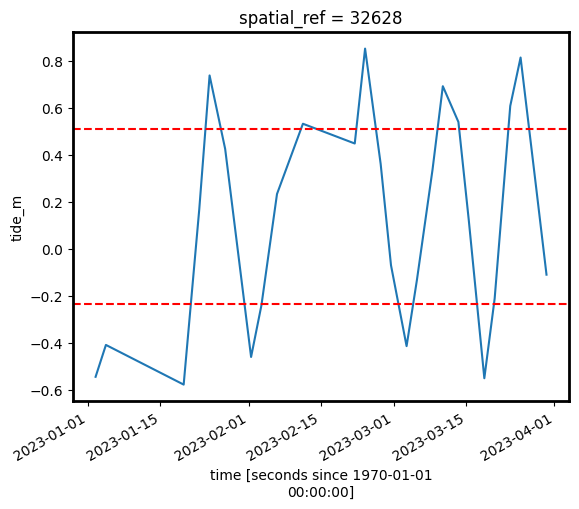

In [13]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = sentinel_2_ds.tide_m.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
sentinel_2_ds.tide_m.plot()
plt.axhline(min_tide, c='red', linestyle='--')
plt.axhline(max_tide, c='red', linestyle='--')
plt.show()


In [ ]:
#rgb(sentinel_2_ds,col='time')

INFO:distributed.utils_perf:full garbage collection released 726.22 MiB from 15188 reference cycles (threshold: 9.54 MiB)


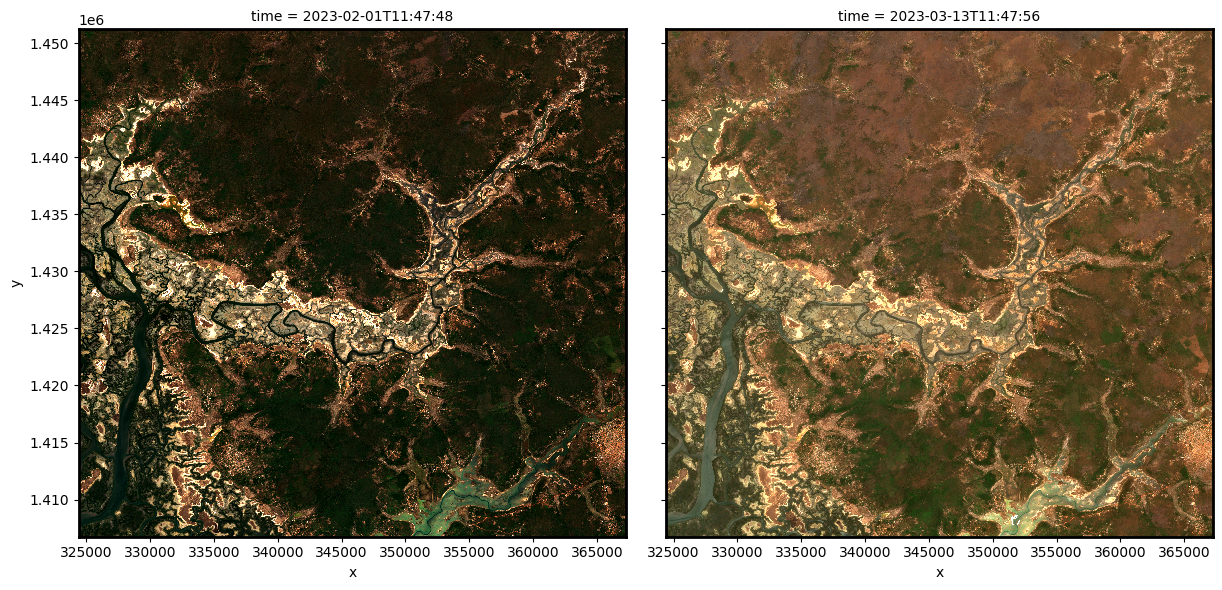

In [17]:
# Set the timesteps to visual
timestep_1 = 6 # marée basse
timestep_2 = 18 # marée haute

# Generate RGB plots at each timestep
rgb(sentinel_2_ds, index=[timestep_1, timestep_2],
   percentile_stretch=[0.01, 0.99])
plt.show()

## Compute band indices
This study measures the presence of water through the normalised difference water index (NDWI), submerged seagrasses through the Submerged Seagrasses Identification Index (SSII) and the non submerged seagrasses through the normalised difference vegetation index (NDVI).

NDWI is calculated from the green and near infrared (NIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}.
\end{aligned}
$$

NDVI is calculated from the red and near infrared (NIR) bands to identify non submerged seagrasses.
The formula is

$$
\begin{aligned}
\text{NDVI} = \frac{\text{Red} - \text{NIR}}{\text{Red} + \text{NIR}}.
\end{aligned}
$$

SSII is calculated from the  first vegetation red edge band, and a is the adjustment factor, which takes a very small value to 
ensure that the denominator is not 0. The value of 0.00001 was taken in the experiment described in this study. [Li and all (2023)](https://doi.org/10.1016/j.marenvres.2023.105880)
The formula is

$$
\begin{aligned}
\text{SSII} = \frac{\text{Red edge 1} }{\text{Red} + \text{a}}.
\end{aligned}
$$

In [18]:
# Calculate NDWI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")

# Calculate EVI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="EVI", collection="s2")

# Calculate NDVI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")

/tmp/ipykernel_478/3835299324.py:2: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")
/tmp/ipykernel_478/3835299324.py:5: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="EVI", collection="s2")
/tmp/ipykernel_478/3835299324.py:8: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")


INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


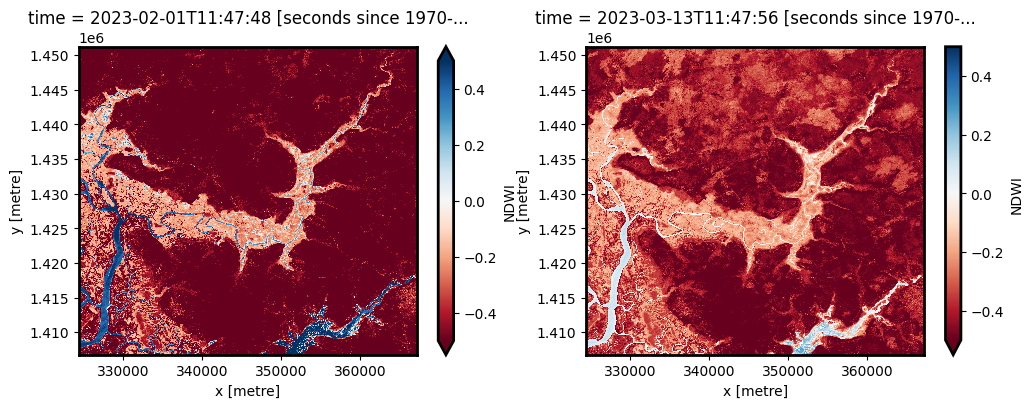

In [23]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 6 # marée basse
timestep_2 = 18 # marée haute

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.NDWI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)

sentinel_2_ds.NDWI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.show()


In [24]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_ha = 100  # conversion from metres to hectares

area_per_pixel = pixel_length**2 / m_per_ha**2

In [25]:
# Filter the data to contain only pixels classified as water
sentinel_2_ds_waterarea = sentinel_2_ds.where(sentinel_2_ds.NDWI.isel(time=timestep_2) > 0.0)

# Calculate the total water area (in ha)
waterarea = (
    sentinel_2_ds_waterarea.NDWI.count(dim=["x", "y"]) * area_per_pixel).persist()

   # .rolling(time=3, center=True, min_periods=1)
   # .median(skipna=True)


In [26]:
a = 0.00001
def SSII(sentinel_2_ds):
    return (sentinel_2_ds.red_edge_1) / (sentinel_2_ds.red + a)

In [27]:
# Calculate the SSII value for Sentinel 2, using water extent to mask
SSII = SSII(sentinel_2_ds_waterarea)

In [ ]:
#SSII.plot()

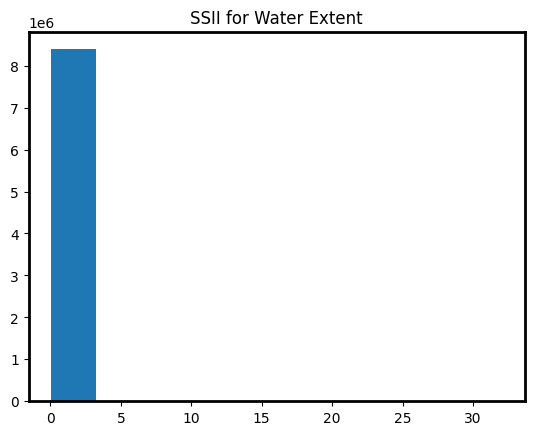

In [28]:
SSII.plot()
plt.title('SSII for Water Extent')
plt.show()


INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


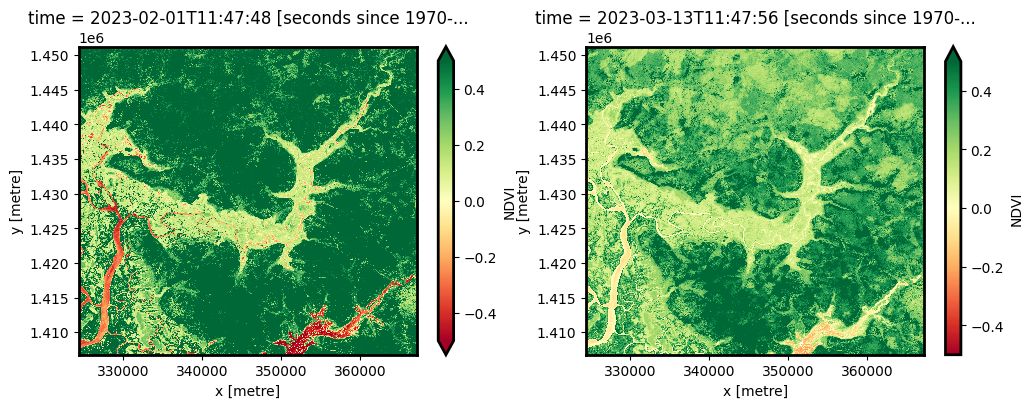

In [29]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 6 # marée basse
timestep_2 = 18 # marée haute

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.NDVI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdYlGn', vmin=-0.5, vmax=0.5)

sentinel_2_ds.NDVI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.show()


INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


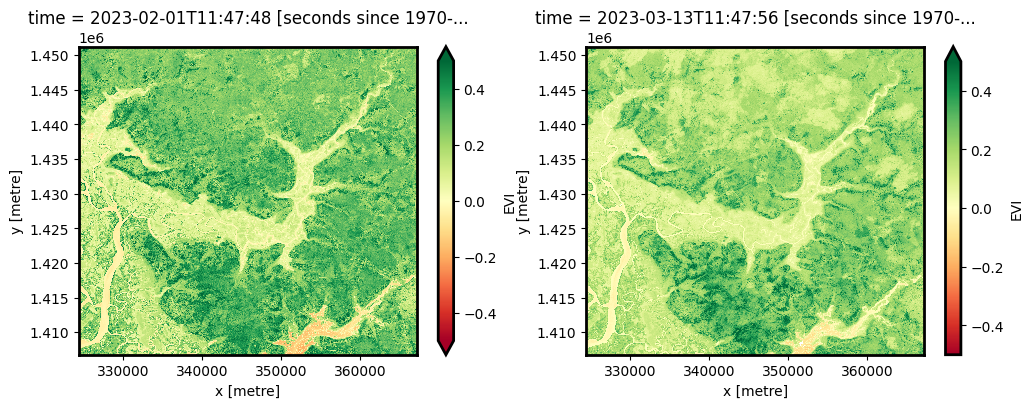

In [30]:
# Plot the resulting image for the same timestep selected above
timestep_1 = 6 # marée basse
timestep_2 = 18 # marée haute

# Plot the resulting image for the same timestep selected above
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sentinel_2_ds.EVI.isel(time=timestep_1).plot(ax=ax[0], cmap='RdYlGn', vmin=-0.5, vmax=0.5)

sentinel_2_ds.EVI.isel(time=timestep_2).plot(ax=ax[1], cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.show()


In [ ]:
# Plot the resulting image for the same timestep selected above
#sentinel_2_ds_low.NDVI.plot(cmap='RdYlGn',size=6, vmin=-0.5, vmax=0.5) #cmap='RdYlGn', 
#plt.show()